# Preliminary Time Series Modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import pickle

In [2]:
# Import test and train data
test = pd.read_feather('data/test.feather')
train = pd.read_feather('data/train.feather')

# Load Yeo-Johnson transformer 
with open('data/yeo_johnson.pkl', 'rb') as f:
    yeo_Johnson = pickle.load(f)

In [3]:
test.head()

,TOTALKWH,tempAvg,winddirAvg,population,density,month,month_sin,month_cos,zipcode,latitude,longitude,YEAR_MONTH
52310,0.745240,-0.950462,-1.173265,0.594556,0.353476,1.640749,0.011083,1.466433,95409.0,38.46116,-122.60425,2023-12-01
50616,-1.314839,-1.013126,0.837214,-1.348510,-1.106715,1.640749,0.011083,1.466433,95410.0,39.21616,-123.70012,2023-12-01
52313,-1.020371,-1.013126,0.837214,-1.348510,-1.106715,1.640749,0.011083,1.466433,95410.0,39.21616,-123.70012,2023-12-01
52316,-1.675422,-0.884477,-0.872962,-1.617928,-1.756972,1.640749,0.011083,1.466433,95412.0,38.71168,-123.31967,2023-12-01
52319,-0.938633,-0.872499,0.700006,-1.116350,-1.075953,1.640749,0.011083,1.466433,95415.0,39.02050,-123.36751,2023-12-01


In [4]:
train.head()

,TOTALKWH,tempAvg,winddirAvg,population,density,month,month_sin,month_cos,zipcode,latitude,longitude,YEAR_MONTH
1153,-1.273660,-1.105724,-0.088299,-1.160380,-1.215160,-1.614009,0.715405,1.276005,93201.0,35.85550,-119.48338,2020-01-01
117,0.142464,-1.527725,0.504476,0.404507,-0.416940,-1.614009,0.715405,1.276005,93203.0,35.12158,-118.84680,2020-01-01
1156,-0.015579,-1.527725,0.504476,0.404507,-0.416940,-1.614009,0.715405,1.276005,93203.0,35.12158,-118.84680,2020-01-01
1159,-0.379155,-0.825427,-1.401082,0.087386,-0.222671,-1.614009,0.715405,1.276005,93204.0,35.90819,-120.06776,2020-01-01
1162,-1.020352,-1.135402,0.000096,-0.958076,-1.321587,-1.614009,0.715405,1.276005,93206.0,35.44402,-119.47578,2020-01-01


Based on the data procecssing steps, it is observced that TOTALKWH, tempAvg, winddirAvg features are time series data and have displayed seasonal changes, whereas population and density are non-seasonal static predictors. Therefore, instead of pure ARIMA/SARIMA (they don't handle external predictors well), I will be using supervised ML models with lag features. 

In [7]:
# Create lag and rolling features
train['lag_1'] = train['TOTALKWH'].shift(1)
train['lag_12'] = train['TOTALKWH'].shift(12)
train['rolling_mean_3'] = train['TOTALKWH'].shift(1).rolling(3).mean()

test['lag_1'] = test['TOTALKWH'].shift(1)
test['lag_12'] = test['TOTALKWH'].shift(12)
test['rolling_mean_3'] = test['TOTALKWH'].shift(1).rolling(3).mean()

In [8]:
test = test.dropna()
train = train.dropna()

In [9]:
features = ['tempAvg', 'winddirAvg', 'population', 'density', 'month_sin', 'month_cos', 'lag_1', 'lag_12', 'rolling_mean_3']
# features = ['tempAvg', 'winddirAvg', 'population', 'zipcode', 'longitude', 'latitude', 'density', 'month_sin', 'month_cos', 'lag_1', 'lag_12', 'rolling_mean_3']
X_train = train[features]
y_train = train['TOTALKWH']
X_test = test[features]
y_test = test['TOTALKWH']

all_data = (X_train, y_train, X_test, y_test)

## Code for implement model training with model improvement through GridSearchCV

In [12]:
def inverse_yeo_johnson(yeo_Johnson, arr):
    """
    Apply inverse Yeo-Johnson transformation to an array using a fitted transformer.

    Parameters:
    - yeo_Johnson: PowerTransformer, fitted Yeo-Johnson transformer
    - arr: array-like, shape (n_samples,), array to inverse transform

    Returns:
    - original_arr: np.ndarray, shape (n_samples,), array after inverse transformation

    Sample Usage:
    original = inverse_yeo_johnson(yeo_transformer, transformed_array)
    """
    arr = np.array(arr).reshape(-1, 1)
    dummy_array = np.zeros((arr.shape[0], yeo_Johnson.n_features_in_))
    dummy_array[:, 0] = arr[:, 0]
    inverse_transformed = yeo_Johnson.inverse_transform(dummy_array)
    original_arr = inverse_transformed[:, 0]
    return original_arr

def train_and_cv(model, param_grid, X_train, y_train, fold, model_name):
    """
    Train a model using GridSearchCV with TimeSeriesSplit and collect cross-validation metrics.

    Parameters:
    - model: model instance
    - param_grid: dict, grid of hyperparameters
    - X_train: training features
    - y_train: training labels
    - fold: int, number of folds
    - model_name: str, name of the model

    Returns:
    - best_model: trained model with best parameters
    - cv_metrics: dict, cross-validation metrics
    """
    tscv = TimeSeriesSplit(n_splits=fold)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    scoring = {
        'mse': mse_scorer,
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error',
    }
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=tscv,
        scoring=scoring,
        refit='rmse',
        n_jobs=-1,
        verbose=3
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    best_idx = grid_search.best_index_

    # Collect cross-validation metrics
    cv_metrics = {
        'model_name': model_name,
        'mse_cv_mean': -grid_search.cv_results_['mean_test_mse'][best_idx],
        'mse_cv_std': grid_search.cv_results_['std_test_mse'][best_idx],
        'rmse_cv_mean': -grid_search.cv_results_['mean_test_rmse'][best_idx],
        'rmse_cv_std': grid_search.cv_results_['std_test_rmse'][best_idx],
        'r2_cv_mean': grid_search.cv_results_['mean_test_r2'][best_idx],
        'r2_cv_std': grid_search.cv_results_['std_test_r2'][best_idx],
    }
    return best_model, cv_metrics


def evaluate(model, X_test, y_test):
    """
    Evaluate model performance on the test set.

    Parameters:
    - model: trained model
    - X_test: testing features
    - y_test: testing labels

    Returns:
    - mse, r2, mae: evaluation metrics
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Inverse transform predictions and actual values
    y_test_original = inverse_yeo_johnson(yeo_Johnson, y_test)
    y_pred_original = inverse_yeo_johnson(yeo_Johnson, y_pred)
    mse_original = mean_squared_error(y_test_original, y_pred_original)
    mae_original = mean_absolute_error(y_test_original, y_pred_original)
    rmse_original = root_mean_squared_error(y_test_original, y_pred_original)
    r2_original = r2_score(y_test_original, y_pred_original)

    return (mse, r2, mae, rmse), (mse_original, r2_original, mae_original, rmse_original)

def modeling(model, dataset, param_grid, fold, model_name):
    """
    Complete modeling pipeline: training, evaluation, saving model, and updating metrics.

    Parameters:
    - model: model instance
    - dataset: tuple (X_train, y_train, X_test, y_test)
    - param_grid: dict, grid of hyperparameters
    - fold: int, number of folds
    - model_name: str, model name

    Returns:
    - best_model: trained best model
    - metrics_row: collected metrics
    """
    X_train, y_train, X_test, y_test = dataset

    best_model, metrics_row = train_and_cv(model, param_grid, X_train, y_train, fold, model_name)
    print(f"Cross-Validation MSE: {metrics_row['mse_cv_mean']:.4f} ± {metrics_row['mse_cv_std']:.4f}")
    print(f"Cross-Validation R2: {metrics_row['r2_cv_mean']:.4f} ± {metrics_row['r2_cv_std']:.4f}")
    print(f"Cross-Validation RMSE: {metrics_row['rmse_cv_mean']:.4f} ± {metrics_row['rmse_cv_std']:.4f}")

    metrics_test, metrics_test_original = evaluate(best_model, X_test, y_test)
    mse_test, r2_test, mae_test, rmse_test = metrics_test
    mse_test_original, r2_test_original, mae_test_original, rmse_test_original = metrics_test_original
    print(f"Test MSE: {mse_test:.4f}")
    print(f"Test R2: {r2_test:.4f}")
    print(f"Test MAE: {mae_test:.4f}")
    print(f"Test RMSE: {rmse_test:.4f}")
    print('\nInverse Transformed:')
    print(f"Test MSE: {mse_test_original:.4f}")
    print(f"Test R2: {r2_test_original:.4f}")
    print(f"Test MAE: {mae_test_original:.4f}")
    print(f"Test RMSE: {rmse_test_original:.4f}")

    return best_model, metrics_row

# Plot the data 
def plot_best_model(best_model, X_test, y_test): 
    results = pd.DataFrame({
        'YEAR_MONTH': test['YEAR_MONTH'].values,
        'Actual': y_test.values,
        'Predicted': best_model.predict(X_test)
    })

    # Sort by time (just in case)
    results = results.sort_values('YEAR_MONTH')

    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(results['YEAR_MONTH'], results['Actual'], label='Actual', marker='o')
    plt.plot(results['YEAR_MONTH'], results['Predicted'], label='Predicted', marker='x')
    plt.xlabel('Date')
    plt.ylabel('TOTALKWH')
    plt.title('Actual vs Predicted TOTALKWH Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Linear Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Linear Regression: {}
Cross-Validation MSE: 0.2817 ± 0.0143
Cross-Validation R2: 0.7231 ± 0.0089
Cross-Validation RMSE: 0.5306 ± 0.0135
Test MSE: 0.2734
Test R2: 0.7439
Test MAE: 0.3442
Test RMSE: 0.5229

Inverse Transformed:
Test MSE: 191468631067958.8438
Test R2: 0.1383
Test MAE: 3536064.1416
Test RMSE: 13837219.0511


D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


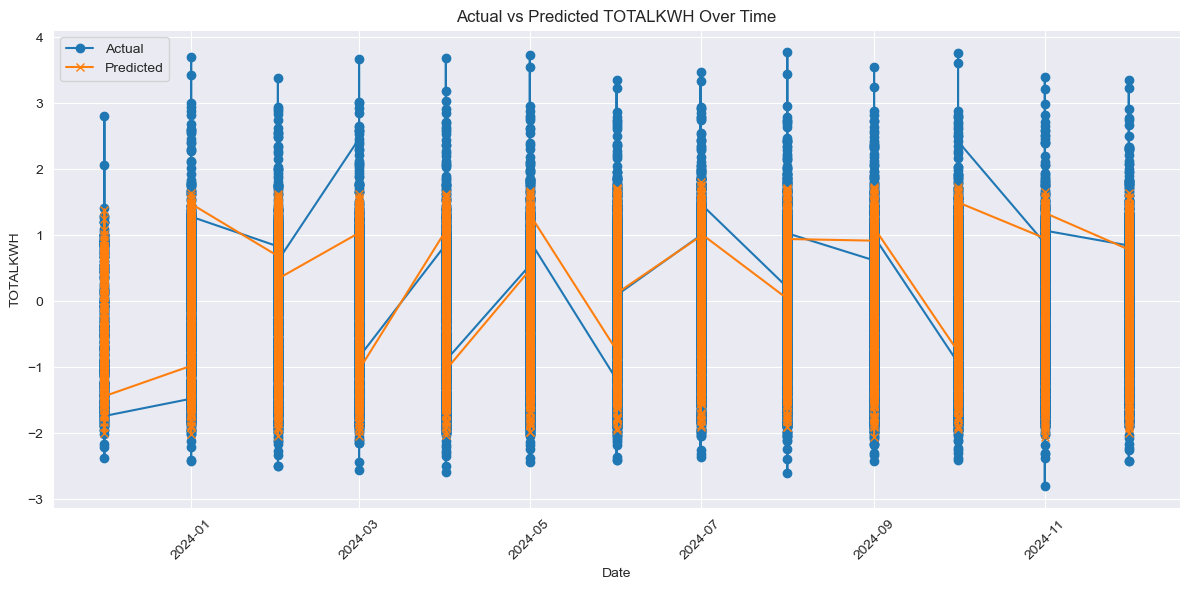

In [16]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()
param_grid_lr = {}
best_model, _ = modeling(linear_regression, all_data, param_grid_lr, 5, 'Linear Regression')

plot_best_model(best_model, X_test, y_test)

## Elastic Net

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Elastic Net: {'alpha': 0.1, 'l1_ratio': 0.1}
Cross-Validation MSE: 0.2938 ± 0.0189
Cross-Validation R2: 0.7115 ± 0.0112
Cross-Validation RMSE: 0.5417 ± 0.0176
Test MSE: 0.2865
Test R2: 0.7316
Test MAE: 0.3655
Test RMSE: 0.5353

Inverse Transformed:
Test MSE: 196480280573709.8438
Test R2: 0.1158
Test MAE: 3562359.1494
Test RMSE: 14017142.3826


D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


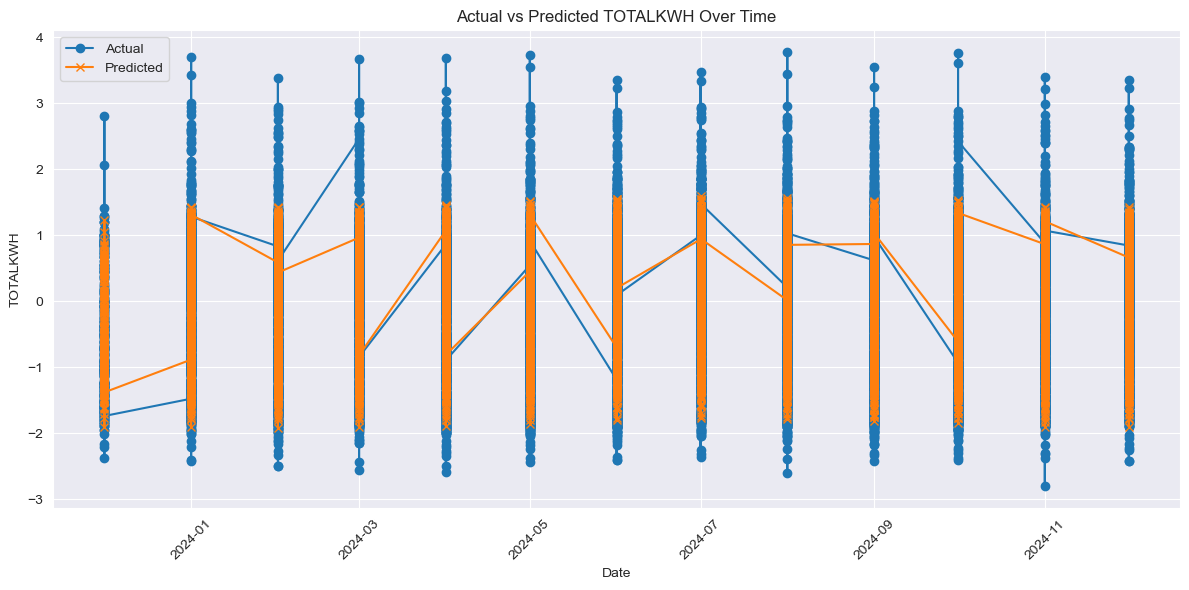

In [17]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(random_state=42)
param_grid_en = {
    'alpha': [0.1, 0.5],  # Regularization strength
    'l1_ratio': [0.1, 0.5]  # Mix ratio between L1 and L2 regularization
}
best_model, _ = modeling(elastic_net, all_data, param_grid_en, 5, 'Elastic Net')

plot_best_model(best_model, X_test, y_test)

## Random Forest

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 0.8, 'min_samples_split': 5}
Cross-Validation MSE: 0.1252 ± 0.0206
Cross-Validation R2: 0.8765 ± 0.0224
Cross-Validation RMSE: 0.3526 ± 0.0285
Test MSE: 0.1020
Test R2: 0.9045
Test MAE: 0.1696
Test RMSE: 0.3193

Inverse Transformed:
Test MSE: 102972501567521.6250
Test R2: 0.5366
Test MAE: 2224929.6719
Test RMSE: 10147536.7241


D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


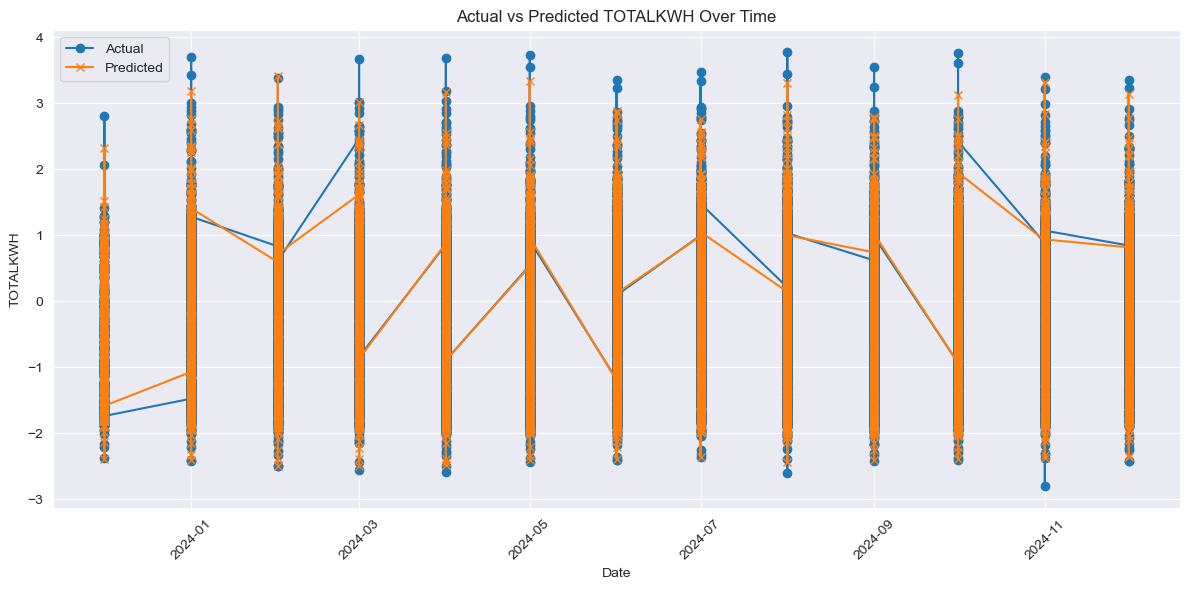

In [18]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_jobs=-1, random_state=42)
param_grid_rf = {
    'max_depth': [10, 20],        # Maximum depth of each tree
    'min_samples_split': [5, 10],       # Minimum samples to split an internal node
    'max_features': ['sqrt', 'log2', 0.8], # Number of features to consider when splitting
    'bootstrap': [True, False]             # Whether to bootstrap samples
}
best_model, _ = modeling(random_forest, all_data, param_grid_rf, 5, 'Random Forest')

plot_best_model(best_model, X_test, y_test)

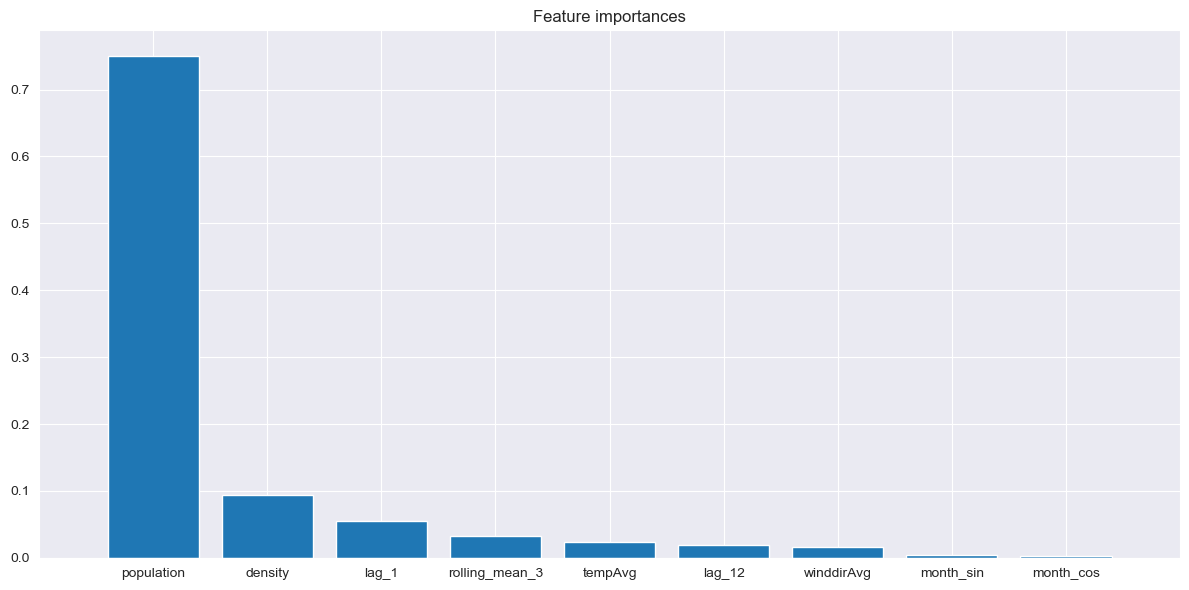

In [19]:
# Plot feature importance
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices])
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## XG Boost Regressor

In [10]:
import xgboost as xgb
# Split features
# remove low importance features
features = ['tempAvg', 'winddirAvg', 'population', 'density', 'lag_1', 'lag_12', 'rolling_mean_3']
# features = ['tempAvg', 'winddirAvg', 'population', 'zipcode', 'longitude', 'latitude', 'density', 'month_sin', 'month_cos', 'lag_1', 'lag_12', 'rolling_mean_3']
X_train = train[features]
y_train = train['TOTALKWH']
X_test = test[features]
y_test = test['TOTALKWH']

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost Regressor: {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 200}
Cross-Validation MSE: 0.1425 ± 0.0171
Cross-Validation R2: 0.8596 ± 0.0183
Cross-Validation RMSE: 0.3769 ± 0.0222
Test MSE: 0.1279
Test R2: 0.8802
Test MAE: 0.2206
Test RMSE: 0.3576

Inverse Transformed:
Test MSE: 138772049814932.4062
Test R2: 0.3755
Test MAE: 2702690.1547
Test RMSE: 11780154.9147


D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\ds\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


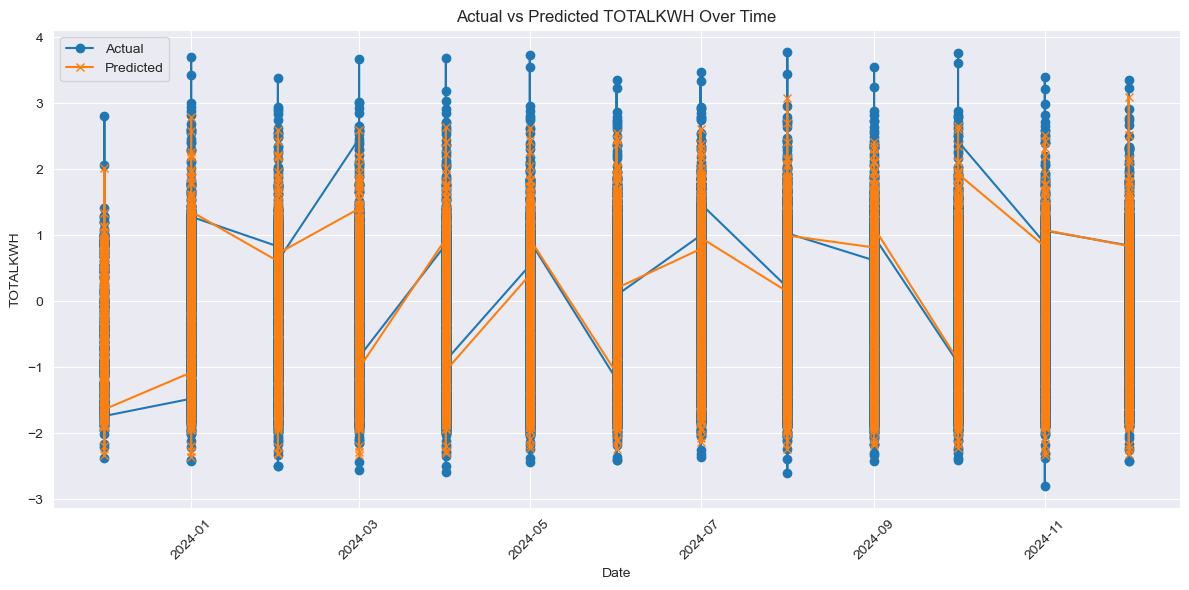

In [15]:
# Fit the model
xgb_model = xgb.XGBRegressor()

param_grid_xgb = {
    'booster': ['gbtree'],  # Type of boosting model
    'n_estimators': [100, 200],  # Number of trees
    'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition
    'learning_rate': [0.01, 0.1],  # Step size shrinkage
}

best_model, _ = modeling(xgb_model, (X_train, y_train, X_test, y_test), 
                         param_grid_xgb, 5, 'XGBoost Regressor')

plot_best_model(best_model, X_test, y_test)

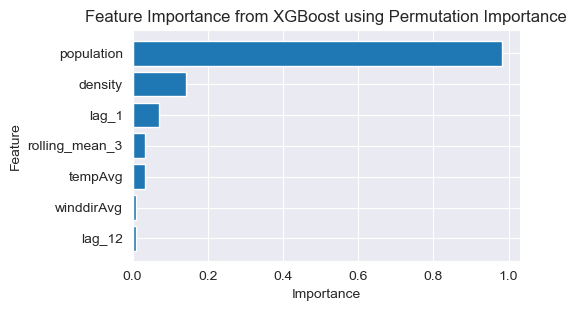

,feature,importance
0,population,0.981468
1,density,0.142566
2,lag_1,0.069141
3,rolling_mean_3,0.034158
4,tempAvg,0.033572
5,winddirAvg,0.009025
6,lag_12,0.008652


In [21]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


def svr_feature_importance(model, X, y, tscv, scoring='neg_root_mean_squared_error',
                           n_repeats=10, random_state=42):
    """
    Compute feature importance for SVR models using K-Fold Cross-Validation and Permutation Importance.

    Parameters:
    - model: instantiated SVR model
    - X: pandas.DataFrame, features
    - y: pandas.Series, labels
    - tscv: TimeSeriesSplit, time series cross-validation object
    - scoring: str, scoring method (default 'neg_root_mean_squared_error')
    - n_repeats: int, number of shuffles for permutation (default 10)
    - random_state: int, random seed
    - plot: bool, whether to plot the importance bar chart

    Returns:
    - feature_importance_df: pandas.DataFrame, sorted feature importances
    """
    importances_list = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        result = permutation_importance(
            model, X_val, y_val,
            scoring=scoring,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=-1
        )
        importances_list.append(result.importances_mean)

    # Average the importances
    mean_importances = np.mean(importances_list, axis=0)
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': mean_importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    # Plot feature importance
    plt.figure(figsize=(5, 3))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.gca().invert_yaxis()
    plt.title('Feature Importance from XGBoost using Permutation Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    return feature_importance_df

svr_feature_importance(best_model, X_train, y_train, 
                       tscv=TimeSeriesSplit(n_splits=5), 
                       scoring='neg_root_mean_squared_error')